 # Анализ оттока клиентов банка

**Цель** - Сформировать рекомендации по удержанию клиентов выделенных сегментов.

**Задача** - Сегментация клиентов,выделение тех, кто склонен уходить из банка.

Заказчик **«Метанпромбанк»**

Датасет содержит данные о клиентах банка, располагающегося в Ярославле и областных городах: Ростов Великий и Рыбинск.

В нашем распоряжении файл bank_scrooge.csv, содержащий следующие данные:

* userid — идентификатор пользователя,
* score — баллы кредитного скоринга,
* City — город,
* Gender — пол,
* Age — возраст,
* Objects — количество объектов в собственности/ equity — количество баллов собственности
* Balance — баланс на счёте,
* Products — количество продуктов, которыми пользуется клиент,
* CreditCard — наличие кредитной карты,
* Loyalty / last_activity — активность клиента,
* estimated_salary — заработная плата клиента,
* Churn — признак оттока - ушёл или нет.

**План:**

##### Шаг 1. Первичная оценка данных:

- оформление/стиль, 
- типы данных, 
- наличие пропусков,
- наличие явных дубликатов.

##### Шаг 2. Предобработка данных: 

- приведение наименований колонок к единому стилю, 
- анализ природы пропусков, обработка - где возможно,
- оценка наличия неявных дубликатов; обработка дубликатов.

##### Шаг 3. Проведение исследовательского анализа: 

- исследование и анализ интервалов значений характеристик, связанных с повышенным оттоком,
- визуализация - построение графиков,
- сравнение портретов "типичных" клиентов, склонных/нет уходить из банка,
- корреляционный анализ (по каждому признаку, оценка по шкале Чеддока).

##### Шаг 4. Формулировка и проверка статистических гипотез.

- гипотеза 1: различие дохода между теми клиентами, которые ушли и теми, которые остались.
- гипотеза 2: различие в оценке крединого рейтинга между теми клиентами, которые ушли и теми, которые остались.

##### Шаг 5. Cегментация пользователей (выделение сегментов, где отток выше, чем средний его уровень по банку).

##### Шаг 6. Приоритизация сегментов.

##### Шаг 7. Общие выводы, формирование рекомендаций.

In [1]:
# импортируем все необходимые библиотеки 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import plotly.io as pio
pio.renderers.default = "png"
from scipy import stats as st
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import normaltest
import phik
from phik.report import plot_correlation_matrix
from phik import report
pd.set_option('mode.chained_assignment', None)

In [2]:
# выгрузим файл с данными
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 
df = pd.read_csv(path)

##### Шаг 1. Первичная оценка данных.

In [3]:
# создадим функцию, чтобы была возможность в один шаг увидеть всю общую информацию

def common_info(df):
    df.info() 
    print('\nПервые строки')
    display(df.head()),
    print('Пропуски'),
    display(df.isna().sum()),
    print('Дубликаты'),
    display(df.duplicated().sum())

In [4]:
common_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB

Первые строки


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


Пропуски


USERID              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
dtype: int64

Дубликаты


0

**При первичной оценке отмечаем:**

* в нашем распоряжении 10.000 записей,
* использование различного регистра в названиях колонок,
* типы данных представлены 3-мя вариантами: object, float64 и int64.
* наличие пропусков в столбцах: age, balance,
* отсуствие явных/полных дубликатов.

##### Шаг 2. Предобработка данных.

**А.** *приведем названия колонок к "змеиному" регистру*

In [5]:
df.columns = df.columns.str.lower()
df = df.rename(columns={'userid': 'user_id'})
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


**Б.** *анализ и обработка пропусков*

In [6]:
#  посмотрим на строки с пропусками в "balance"
no_balance = df[df['balance'].isnull()]
no_balance.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0
10,148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0
11,172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0
19,127034,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0


In [7]:
#  посмотрим на строки с пропусками в "age"
no_age = df[df['age'].isnull()]
no_age.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0
2444,221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1
4912,210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0


In [8]:
# посмотрим на строки где пропуски и в возрасте, и в балансе
no_balance_no_age = df[df[['age','balance']].isna().all(1)]
no_balance_no_age

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0
2444,221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0
5495,151662,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0
7248,219343,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0
8015,198635,670.0,Ярославль,Ж,NaN,0,NaN,1,1,1,168699.33,0
8070,226550,940.0,Рыбинск,М,NaN,0,NaN,1,0,1,147696.95,0
8293,216848,930.0,Ярославль,М,NaN,0,NaN,1,1,1,199542.51,0
8385,206759,915.0,Рыбинск,М,NaN,0,NaN,1,1,0,71179.53,0
8449,210898,805.0,Ярославль,Ж,NaN,0,NaN,1,0,1,922080.25,0
8632,221197,893.0,Ярославль,М,NaN,0,NaN,1,1,0,173929.92,0


In [9]:
# для дальнейшего анализа пропусков создадим доп. столбцы
# 1 - значение пропущено, 0 - значение не пропущено
df['age_Nan'] = np.where(df['age'].isnull(), 1,0)
display(df.head())
df['balance_Nan'] = np.where(df['balance'].isnull(), 1,0)
df.head()


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_Nan
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_Nan,balance_Nan
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0


In [10]:
# новый признак(age_Nan и balance_Nan) используем как столбец сводной таблицы
# по каждому признаку посчитаем меру центральной тендеции

nan_in_age = df.groupby('age_Nan')\
    .agg({ 'est_salary' : 'mean', 'age' : 'mean',
           'products': 'median', 'equity': 'median',
           'gender' : pd.Series.mode, 'city': pd.Series.mode
          }).round(2).T
nan_in_age = nan_in_age.rename(columns={0: "Значение не пропущено", 1: "Значение пропущено"})

def calc_diff(row):
    if row.name in ['est_salary', 'age','products', 'equity']:
        return ((row['Значение не пропущено'] - row['Значение пропущено'])/ row['Значение не пропущено']) * 100
    else:
        return '-'

nan_in_age['Относительная разница,%'] = nan_in_age.apply(calc_diff, axis=1)
display(nan_in_age)


nan_in_balance = df.groupby('balance_Nan')\
    .agg({ 'est_salary' : 'mean', 'age' : 'mean',
           'products': 'median', 'equity': 'median',
           'gender' : pd.Series.mode, 'city': pd.Series.mode
          }). T
nan_in_balance = nan_in_balance.rename(columns={0: "Значение не пропущено", 1: "Значение пропущено"})


nan_in_balance['Относительная разница,%'] = nan_in_balance.apply(calc_diff, axis=1)
nan_in_balance

age_Nan,Значение не пропущено,Значение пропущено,"Относительная разница,%"
est_salary,147786.81,178585.2,-20.839742
age,42.73,NaN,NaN
products,2.0,1.0,50.0
equity,3.0,0.0,100.0
gender,М,М,-
city,Ярославль,Ярославль,-


balance_Nan,Значение не пропущено,Значение пропущено,"Относительная разница,%"
est_salary,124501.872366,226310.208654,-81.772534
age,42.924366,42.093023,1.936763
products,2.0,1.0,50.0
equity,4.0,0.0,100.0
gender,Ж,М,-
city,Ярославль,Ярославль,-


In [11]:
# посмотрим на некоторые зависимости/особенности прицельнее
df.groupby('city').count()

,user_id,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_Nan,balance_Nan
city,,,,,,,,,,,,,
Ростов,1417,1417,1417,1416,1417,1182,1417,1417,1417,1417,1417,1417,1417
Рыбинск,2695,2695,2695,2683,2695,2102,2695,2695,2695,2695,2695,2695,2695
Ярославль,5888,5888,5888,5875,5888,4421,5888,5888,5888,5888,5888,5888,5888


Наибольшее количество клиентов приходится на Ярославль, однако, и подавляющее большинство пропусков в *balance* в том же городе **~ 25 %.**

По возрасту - кроме одного попуска, они располагаются в г. Рыбинск и Ярославль. **%** очень низок. 

Наиболее значимую разницу мы видим для заработной платы(относительно "balance").

После оценки дубликатов завершим анализ пропусков.


**В.** *оценим/обработаем неявные дубликаты.*

In [12]:
#  для поиска дубликатов используем 2 столбца
df[df.duplicated(subset=['user_id', 'score'])]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_Nan,balance_Nan
9104,222480,776.0,Рыбинск,Ж,NaN,5,796735.09,1,1,1,55073.63,0,1,0
9457,141945,929.0,Ярославль,М,NaN,0,NaN,1,1,0,381868.89,0,1,1
9634,221809,917.0,Ярославль,М,NaN,0,NaN,1,1,1,192644.15,0,1,1


Найдено **3** неполных дубликата, но, прежде чем принимать решения об обработке, посмотрим прицельно на строки, идентифицируемые как дубликаты.

In [13]:
df[df['user_id']==222480]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_Nan,balance_Nan
6446,222480,776.0,Ярославль,Ж,38.0,5,823145.83,2,1,1,55777.44,0,0,0
9104,222480,776.0,Рыбинск,Ж,NaN,5,796735.09,1,1,1,55073.63,0,1,0


In [14]:
df[df['user_id']==141945]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_Nan,balance_Nan
4343,141945,929.0,Рыбинск,М,33.0,0,NaN,1,1,0,381868.89,0,0,1
9457,141945,929.0,Ярославль,М,NaN,0,NaN,1,1,0,381868.89,0,1,1


In [15]:
df[df['user_id']==221809]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_Nan,balance_Nan
9322,221809,917.0,Рыбинск,М,45.0,0,NaN,1,1,1,199728.29,0,0,1
9634,221809,917.0,Ярославль,М,NaN,0,NaN,1,1,1,192644.15,0,1,1


Все "дубликаты" объединяет общий user_id, score. Однако, обратим внимание, что город разный; возраст заполнен только в одной из строчек, зарплата идентична или отличие не велико. Можно предположить, что это продукты одного клиента открытые в разных филиалах? Удалять данные строки не будем.

Возвращаясь к пропускам: опираясь на значения относительной разницы, полученные при сравнении признаков в разбивке на пропущенное/нет значение в можем отнести пропуски к категории MNAR — пропуски зависят от данных.

Однако, учитывая кол-во пропусков в "age" и найденные закономерности принято решение заполнить их средним значением, а пропуски в "balance" не трогать.

In [16]:
df['age'] = df['age'].fillna(df['age'].mean())
df.drop('age_Nan', axis=1, inplace=True)

In [17]:
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_Nan
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0


**Шаг 2. Итоги:**

- наименования колонок приведены к "змеиному" регистру;
- пропуски проанализированы, определены в категорию MNAR, заполнены средним в 'age', в 'balance' - оставлены не тронутыми;
- найденные неполные дубликаты таковыми не являются, принято решение оставить их без изменений. 

##### Шаг 3. Проведение исследовательского анализа.

In [18]:
# посмотрим на распределение имеющихся данных
round(df.describe(),2)

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_Nan
count,10000.00,10000.00,10000.00,10000.00,7.705000e+03,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,171814.71,848.70,42.73,2.63,8.277943e+05,1.87,0.68,0.52,147866.89,0.18,0.23
std,33708.24,65.45,12.16,1.98,1.980614e+06,0.79,0.47,0.50,139388.51,0.39,0.42
min,94561.00,642.00,18.00,0.00,0.000000e+00,0.00,0.00,0.00,2546.30,0.00,0.00
25%,142810.25,802.00,33.00,0.00,2.955542e+05,1.00,0.00,0.00,75251.90,0.00,0.00
50%,172728.00,853.00,40.00,3.00,5.242722e+05,2.00,1.00,1.00,119658.10,0.00,0.00
75%,201261.75,900.00,51.00,4.00,9.807058e+05,2.00,1.00,1.00,174500.54,0.00,0.00
max,229145.00,1000.00,86.00,9.00,1.191136e+08,5.00,1.00,1.00,1395064.45,1.00,1.00


Что может отметить первично:

* макс возраст клиента банка 86 лет
* оценка объектов нед-ти/кол во их в собественности варьируется от 0 до 9
* макс кол-во продуктов  в пользовании - 5
* 68 % клиентов пользуются кредитной картой
* неактивные клиенты ~ 50 % 
* общий % оттока ~ 18 %

Есть 2 столбца 'balance'  и 'est_salary' с большим разбросом значений, "приглядимся" к ним пристальнее.

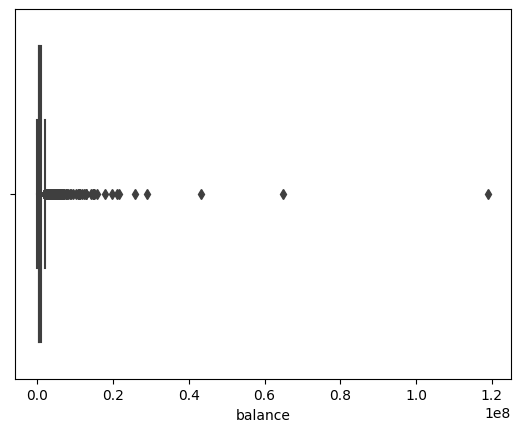

In [19]:
sns.boxplot(x='balance', data=df);

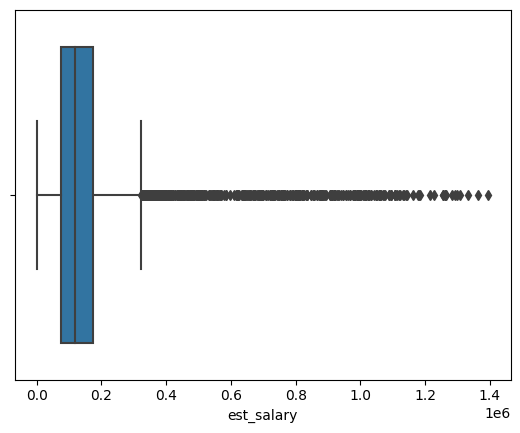

In [20]:
sns.boxplot(x='est_salary', data=df);

Видим наличие выбросов, однако, не будем спешить их удалять. Учтем это при визуализации.

**А.** *Исследование и анализ интервалов значений характеристик, связанных с повышенным оттоком.*

In [21]:
# cделаем общую оценку  - посмотрим на средние значения признаков в двух группах —  отток (1), не отток (0).
df.groupby('churn').agg('mean').T.round(2)

churn,0,1
user_id,172004.36,170962.35
score,845.43,863.40
age,43.02,41.45
equity,2.37,3.76
balance,733982.59,1133993.27
products,1.76,2.38
credit_card,0.71,0.55
last_activity,0.48,0.70
est_salary,147783.20,148243.01
balance_Nan,0.28,0.01


**Отмечаем:**
* Кол-во объектов в собственности больше у отточных клиентов; 
* Остаток на балансе больше у отточных;
* Активность выше у отточных;
* А по крединым картам лидируют не отточные. 

**Б.** *Визуализация*

Помним, что общий отток по банку **~ 18 %**. Посмотрим отток в разрезе различных признаков. 

In [22]:
# создадим функцию для оценки отток/не отток для категориальных признаков
# % оттока по банку будет отмечен карсной пунктирной линией

def categorical_sign_to_churn(column, title, new_name):
    
    data = df.query('products!=0') \
    .groupby([column, 'churn']) \
    .agg({'user_id':'count'})\
    .rename(columns=({'user_id':'count_by_churn'}))\
    .reset_index()
    data['total'] = data.groupby(column)['count_by_churn'].transform('sum')
    data
    data['percent,%'] = \
    round(data['count_by_churn'] /data['total']*100,2)
    display(data)

    fig = px.bar(data.query('churn==1'), x=column, y="percent,%",\
             text_auto='percent,%', width=800,height =500,\
             labels={
                     column: new_name,
                     "percent,%": "%",
                 },
                title=title)
    
    fig.add_hline(y=18, line_dash="dash", line_color="red")
    
    fig.show()
    

    fig = px.box(data, x=column, y='count_by_churn',width=800,height =500,
                labels={
                     column: new_name,
                     "count_by_churn": "Количество пользователей",
                 }
                )
    fig.show()

,gender,churn,count_by_churn,total,"percent,%"
0,Ж,0,4358,4994,87.26
1,Ж,1,636,4994,12.74
2,М,0,3822,5005,76.36
3,М,1,1183,5005,23.64


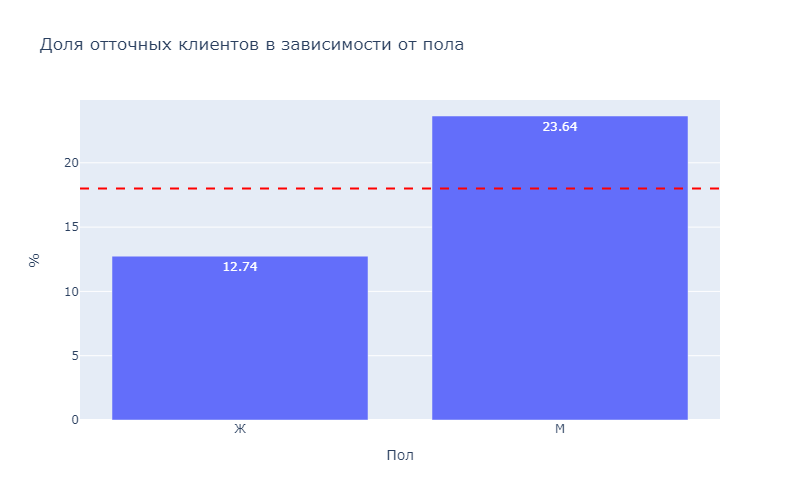

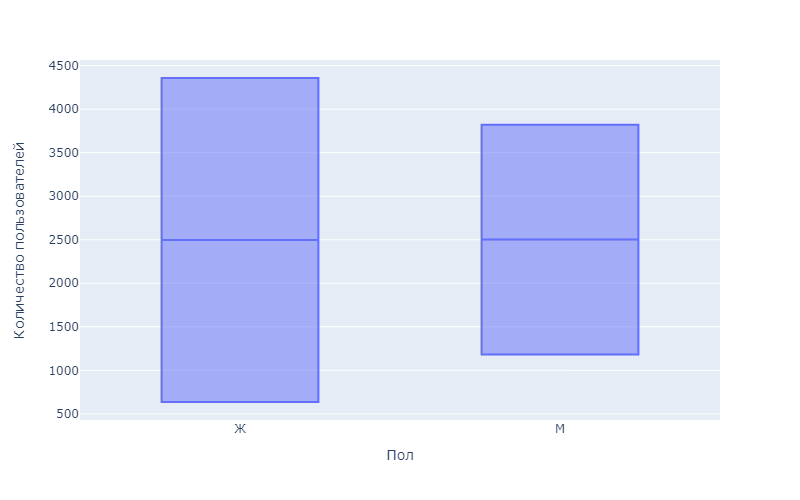

In [23]:
# пол
categorical_sign_to_churn('gender',"Доля отточных клиентов в зависимости от пола","Пол")


Соотношение женщины/мужчины среди клиентов банка практически **1:1** *(4995 / 5005).*
Однако, отточных среди мужчин больше,чем среди женщин. *М* - **23,64 %**( выше общебанковского оттока), *Ж* - **12,75 %.**
Вероятно, данный признак будет иметь корреляцию с оттоком.

,city,churn,count_by_churn,total,"percent,%"
0,Ростов,0,1151,1417,81.23
1,Ростов,1,266,1417,18.77
2,Рыбинск,0,2258,2694,83.82
3,Рыбинск,1,436,2694,16.18
4,Ярославль,0,4771,5888,81.03
5,Ярославль,1,1117,5888,18.97


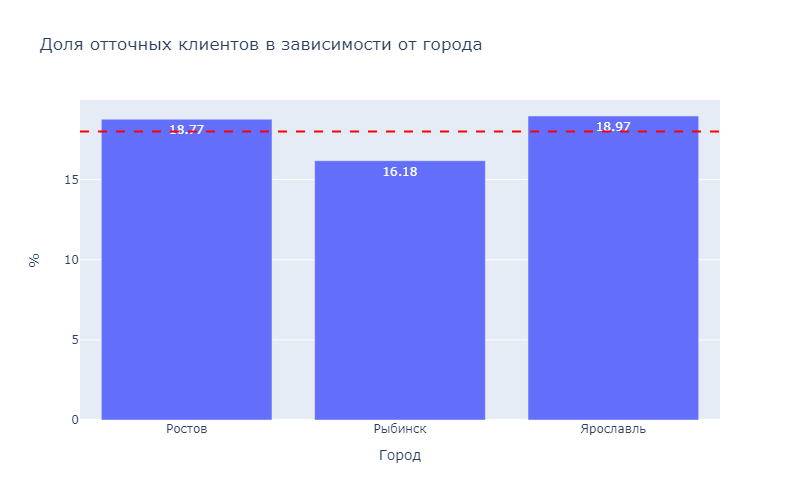

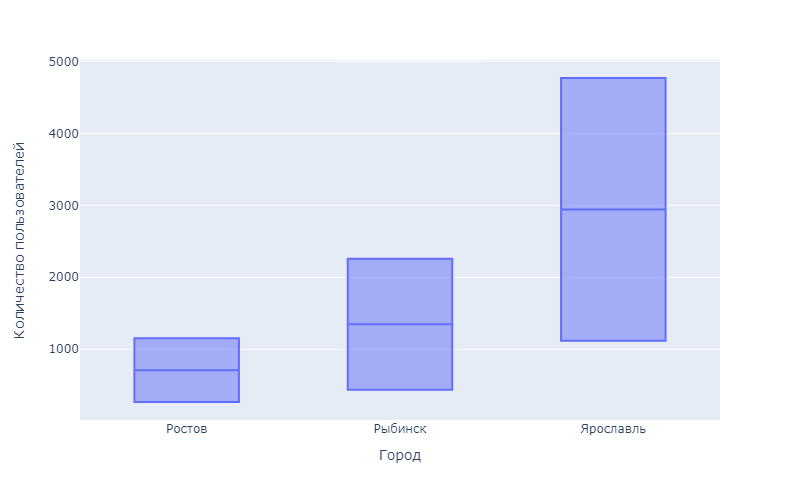

In [24]:
# город
categorical_sign_to_churn('city',"Доля отточных клиентов в зависимости от города","Город")

Соотношение клиентов по городам:
- Ярославль 5888 (58,88 %), 
- Рыбинск   2695 (26,95 %),
- Ростов    1417 (14,17 %).

Самый низкий % оттока в Рыбинске. Практически одинаковый в Ярославле и Ростове ( **18.97%** и **18.77%**) и на уровне общебанковского. Вероятно, данный признак будет иметь низкую корреляцию с оттоком.

,equity,churn,count_by_churn,total,"percent,%"
0,0,0,2502,2592,96.53
1,0,1,90,2592,3.47
2,1,0,681,774,87.98
3,1,1,93,774,12.02
4,2,0,886,1052,84.22
5,2,1,166,1052,15.78
6,3,0,1221,1542,79.18
7,3,1,321,1542,20.82
8,4,0,1386,1850,74.92
9,4,1,464,1850,25.08


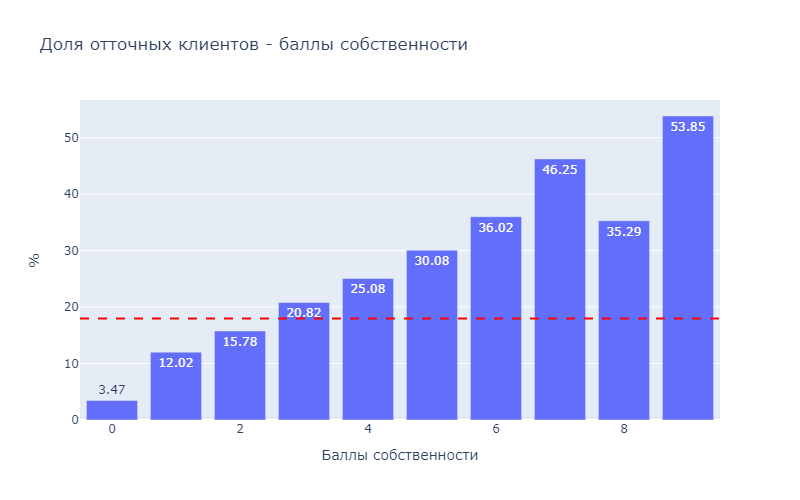

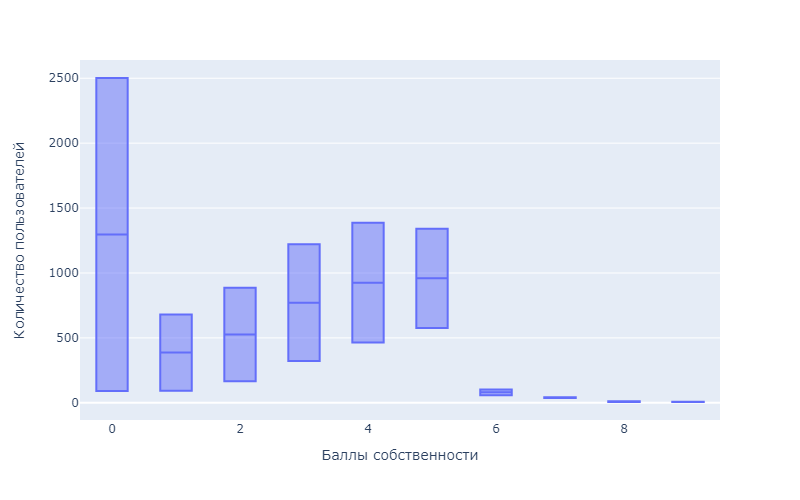

In [25]:
# кол-во баллов в собственности
categorical_sign_to_churn('equity',"Доля отточных клиентов - баллы собственности","Баллы собственности")

По кол-ву баллов собственности мы видим *прогрессирующее увеличение %* отточных клиентов с *увеличением балла*. Макс % оттока - **53.85 %.** Отметим, что **25 %** от всех клиентов имеют балл 0. Вероятно, данный признак будет иметь корреляцию с оттоком.

,products,churn,count_by_churn,total,"percent,%"
0,1,0,3106,3341,92.97
1,1,1,235,3341,7.03
2,2,0,4147,5126,80.90
3,2,1,979,5126,19.10
4,3,0,742,1039,71.41
5,3,1,297,1039,28.59
6,4,0,174,474,36.71
7,4,1,300,474,63.29
8,5,0,11,19,57.89
9,5,1,8,19,42.11


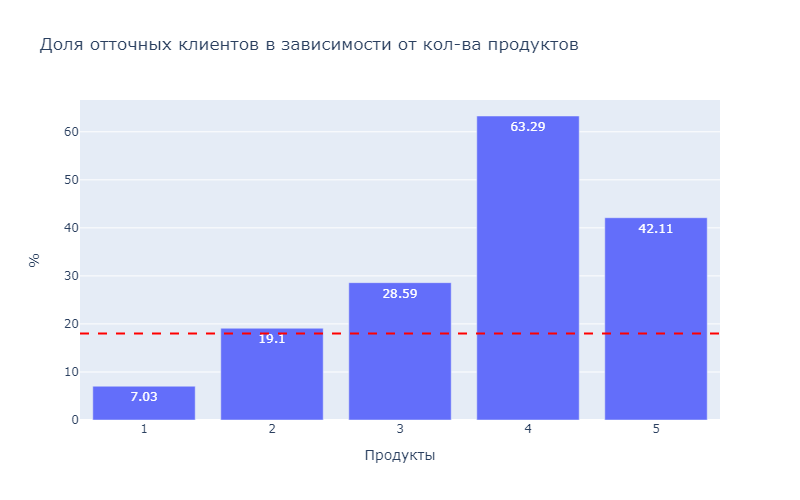

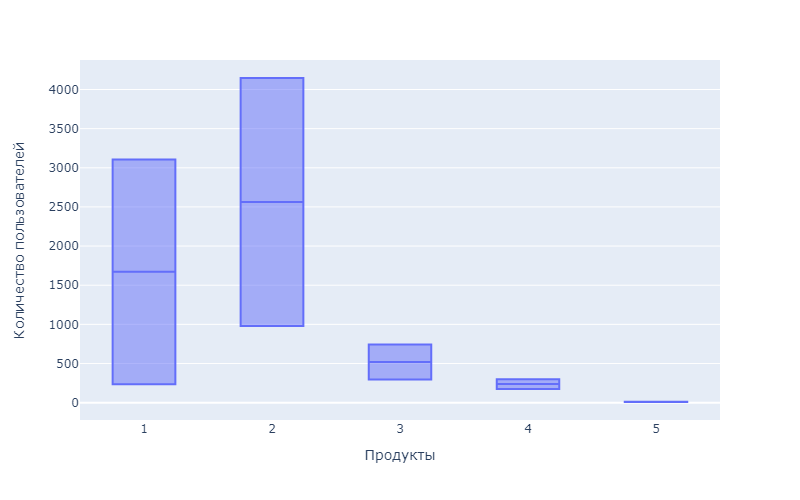

In [26]:
# наличие продуктов
categorical_sign_to_churn('products',"Доля отточных клиентов в зависимости от кол-ва продуктов","Продукты")

По кол-ву продуктов, также, видим прогрессирующее увеличение % отточных клиентов с увеличением кол-ва продуктов. 
Макс % оттока - **63.29 %**(4 продукта). Отметим, что **50 %** от всех клиентов пользуются 2-мя продуктами. Вероятно, данный признак будет иметь корреляцию с оттоком.

,credit_card,churn,count_by_churn,total,"percent,%"
0,0,0,2379,3195,74.46
1,0,1,816,3195,25.54
2,1,0,5801,6804,85.26
3,1,1,1003,6804,14.74


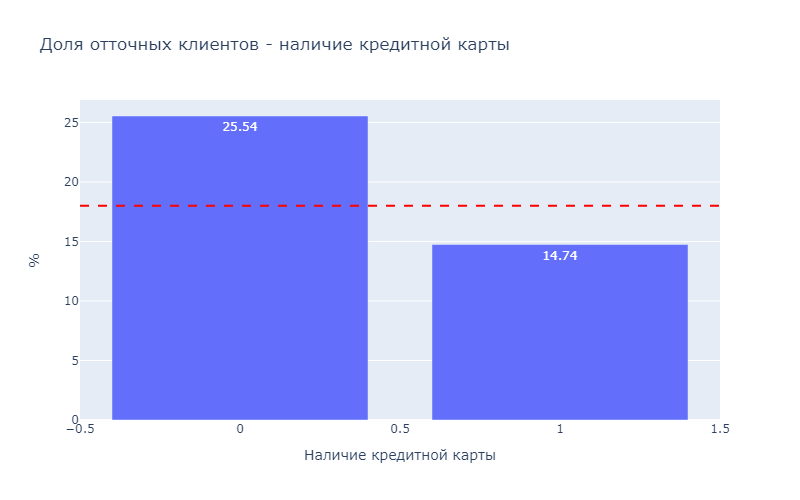

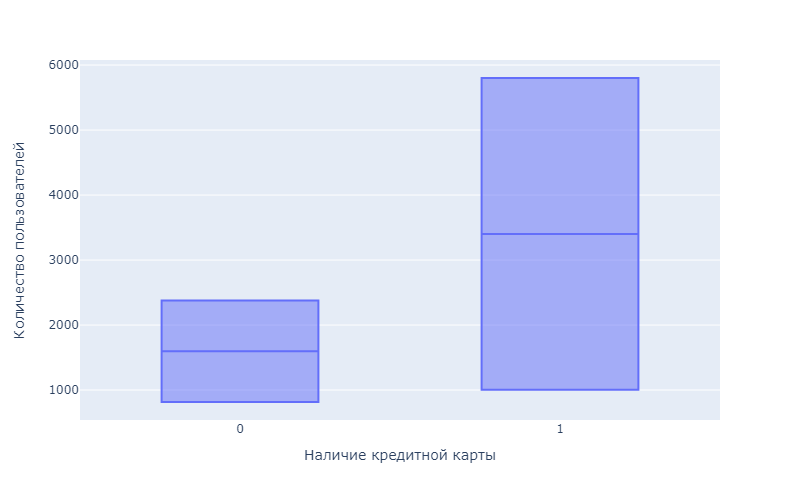

In [27]:
# наличие кредитной карты
categorical_sign_to_churn('credit_card',"Доля отточных клиентов - наличие кредитной карты","Наличие кредитной карты")

~ **70 %**(6804) клиентов банка имеют кредитную карту, при этом % отточных среди них ниже среднебанковского - **14.74 %.**
А вот среди не имеющих кредитную карту - **25.56%**. Вероятно, данный признак будет иметь корреляцию с оттоком.

,last_activity,churn,count_by_churn,total,"percent,%"
0,0,0,4223,4764,88.64
1,0,1,541,4764,11.36
2,1,0,3957,5235,75.59
3,1,1,1278,5235,24.41


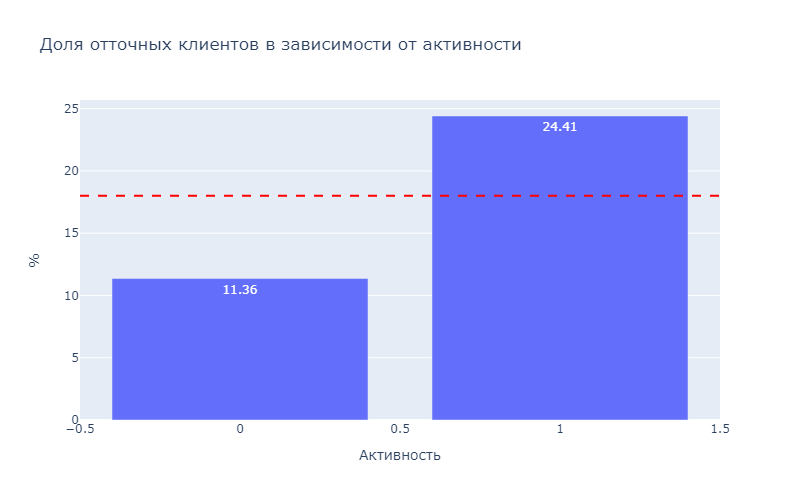

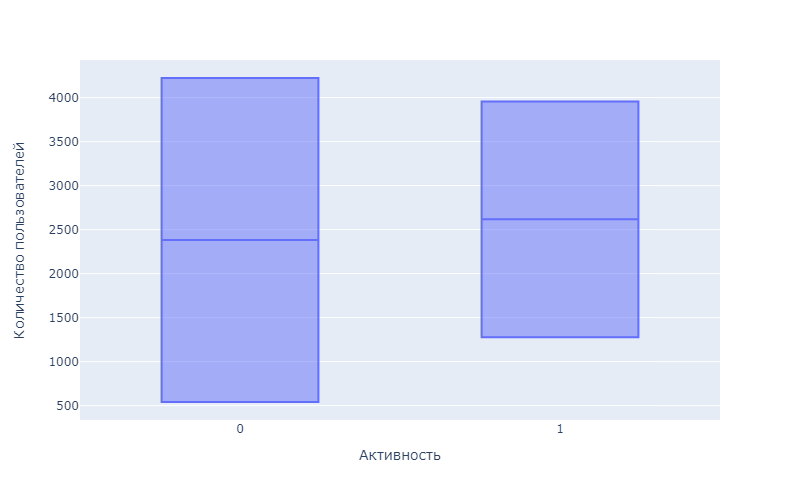

In [28]:
# активность 
categorical_sign_to_churn('last_activity',"Доля отточных клиентов в зависимости от активности","Активность")

Соотношение активные/неактивные среди клиентов банка близко к  **1:1** *(4765 / 5235).*
Однако, отточных больше среди активных - **24.41 %**( выше общебанковского оттока). Вероятно, данный признак будет иметь корреляцию с оттоком.

In [29]:
# создадим функцию для оценки отток/не отток для числовых признаков

def numeric_sign_to_churn(column,width,height,title,title_1,new_name):
    
    fig = px.histogram(df, x=column, color="churn", histnorm='probability', barmode ='overlay',width=width,height =height,
                       labels={
                     column: new_name
                 },
                      title=title)
    fig.update_layout(yaxis_title="%") 
    fig.show()

    fig = px.box(df, x='churn', y=column,width=1000,height =700,
                     labels={
                     column: new_name
                 },
                 title = title_1)
    fig.update_layout(xaxis_title="Признак отточности") 
                
    fig.show()


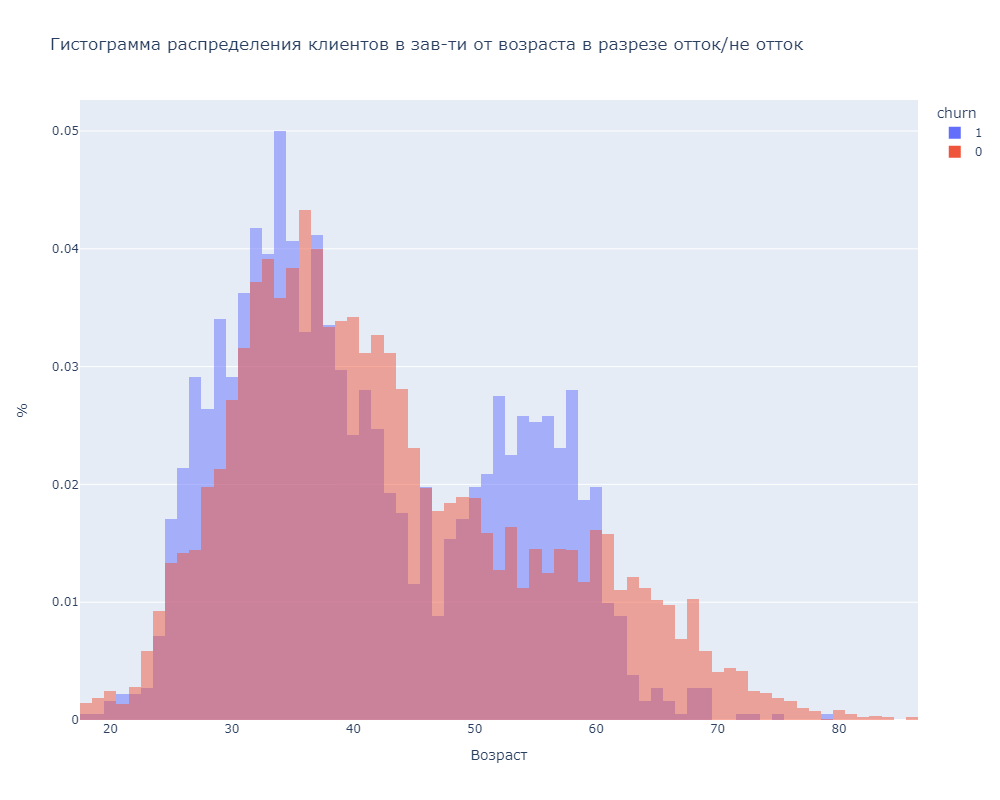

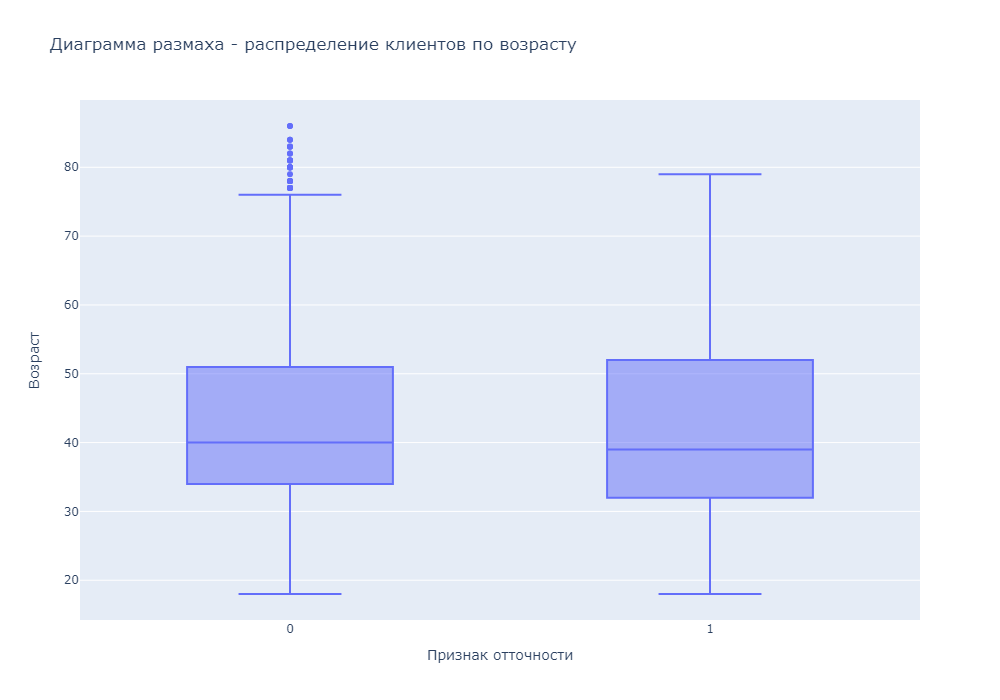

In [30]:
numeric_sign_to_churn('age', 
                      1000, 800, 
                      "Гистограмма распределения клиентов в зав-ти от возраста в разрезе отток/не отток",
                      "Диаграмма размаха - распределение клиентов по возрасту",
                      "Возраст")

Медианный возраст отточных/нет клиентов практически аналогичен (39/40). В интервале **25 - 35 лет** и **50 - 60 лет** отток преобладает. Позднее оценим общую корреляцию данного признака. 

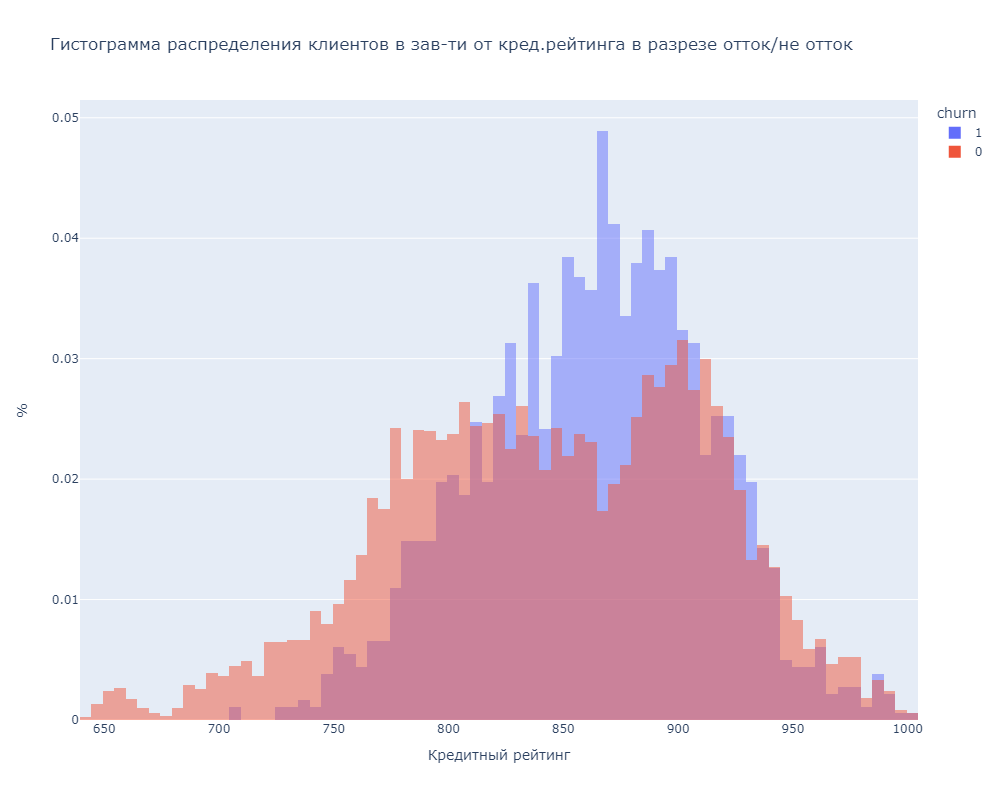

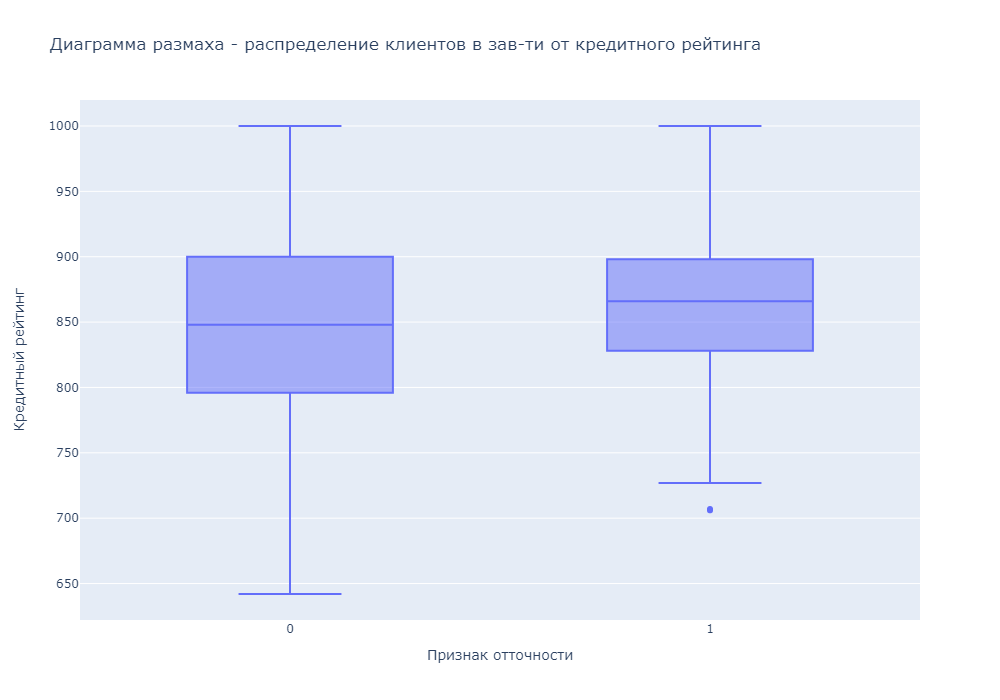

In [31]:
# кредитный рейтинг 
numeric_sign_to_churn('score', 
                      1000, 800, 
                      "Гистограмма распределения клиентов в зав-ти от кред.рейтинга в разрезе отток/не отток",
                      "Диаграмма размаха - распределение клиентов в зав-ти от кредитного рейтинга",
                      "Кредитный рейтинг"
                     )


Медианный кредитный рейтинг отточных/нет клиентов выше у отточных - *866*. В интервалах **820 - 829, *835 - 909*, 920 - 934** отток преобладает. Позднее оценим общую корреляцию данного признака. 

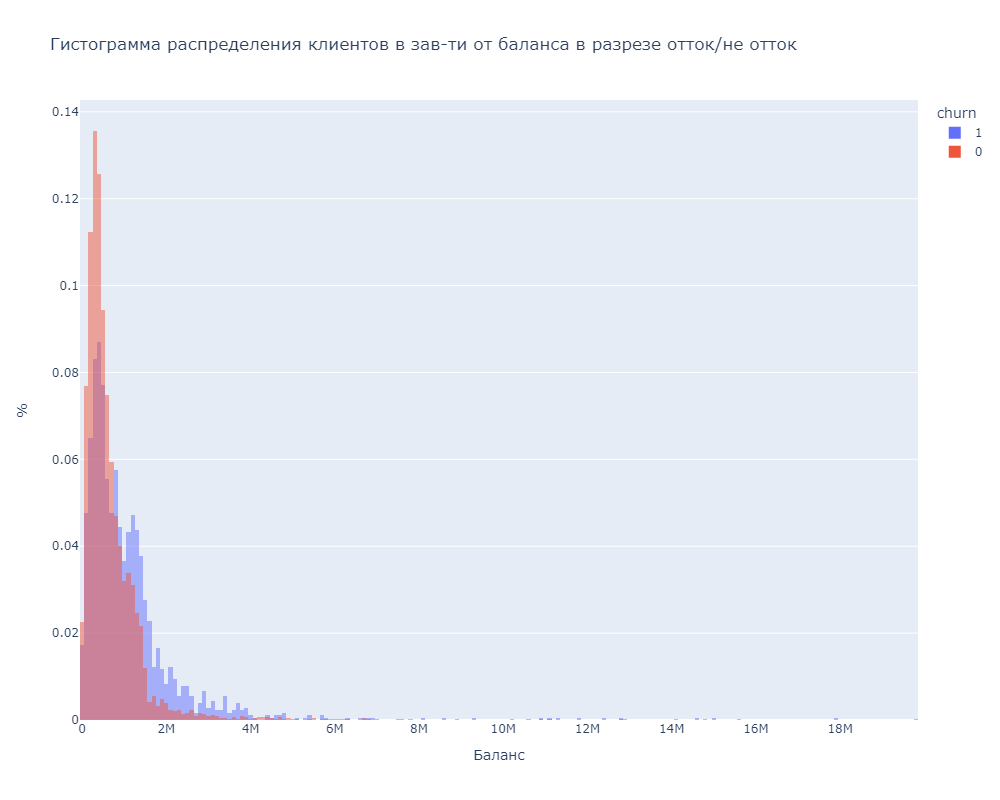

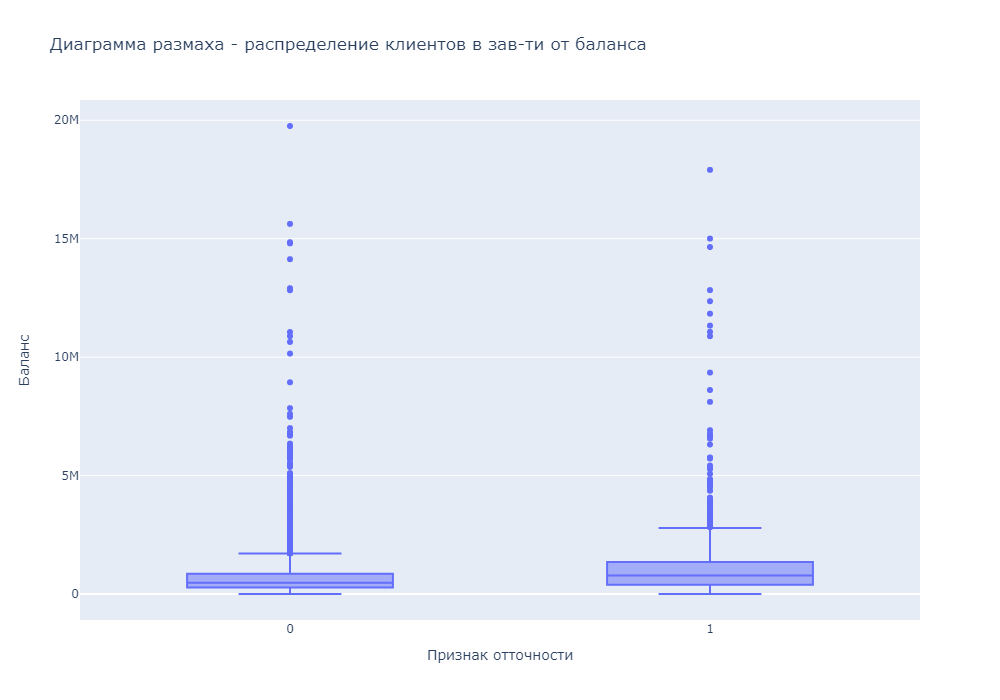

In [32]:
# далее нам необходимо посмотреть 2 признака - баланс и зп
# ранее мы построили "ящик с усами", оценили данные, в т.ч.выбросы; 
# чтобы гистограмма была читаема "обрежем" часть значений так, что это не измениn рез-т

df_to_balance = df.query('balance <=20000000')

fig = px.histogram(df_to_balance, x='balance', color="churn", histnorm='probability', 
                       barmode ='overlay',width=1000,height =800,
                       labels={
                     'balance': 'Баланс'
                 },
                      title="Гистограмма распределения клиентов в зав-ти от баланса в разрезе отток/не отток")
fig.update_layout(yaxis_title="%") 
fig.show()

fig = px.box(df_to_balance, x='churn', y='balance',width=1000,height =700,
                     labels={
                     'balance': 'Баланс'
                 },
                 title =  "Диаграмма размаха - распределение клиентов в зав-ти от баланса")
fig.update_layout(xaxis_title="Признак отточности") 
                
fig.show()


Медианный баланс отточных/нет клиентов выше у отточных ~ *780 K*. Начиная с **750 К** отток начинает стабильно преобладать. Позднее оценим общую корреляцию данного признака. 

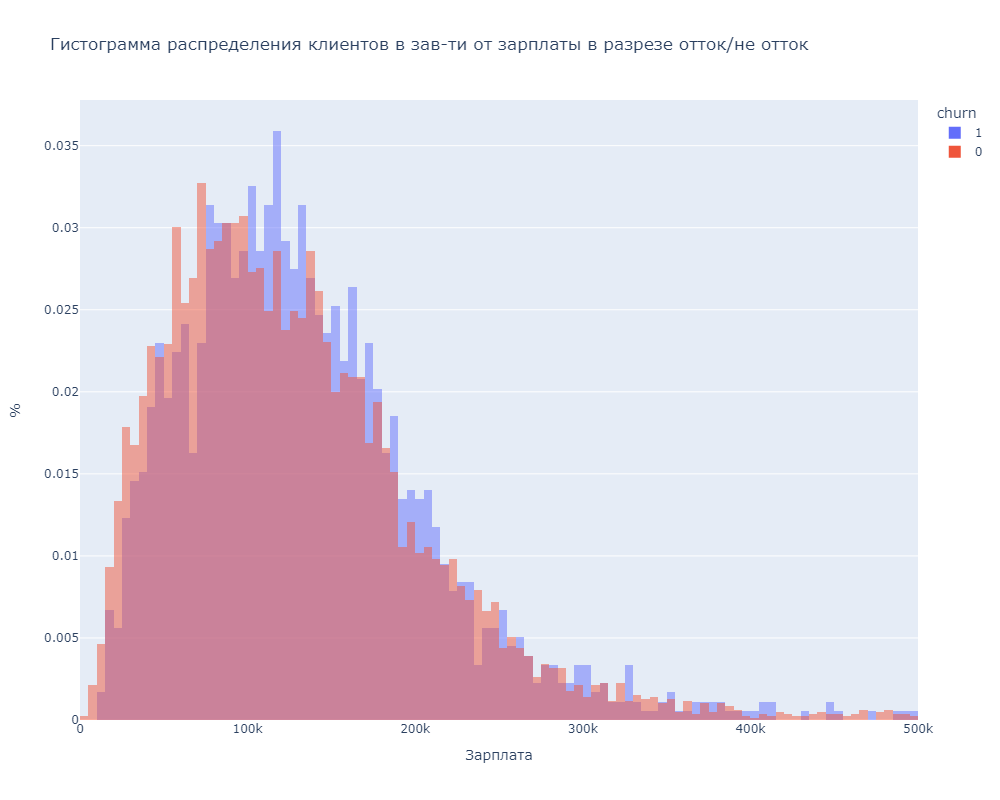

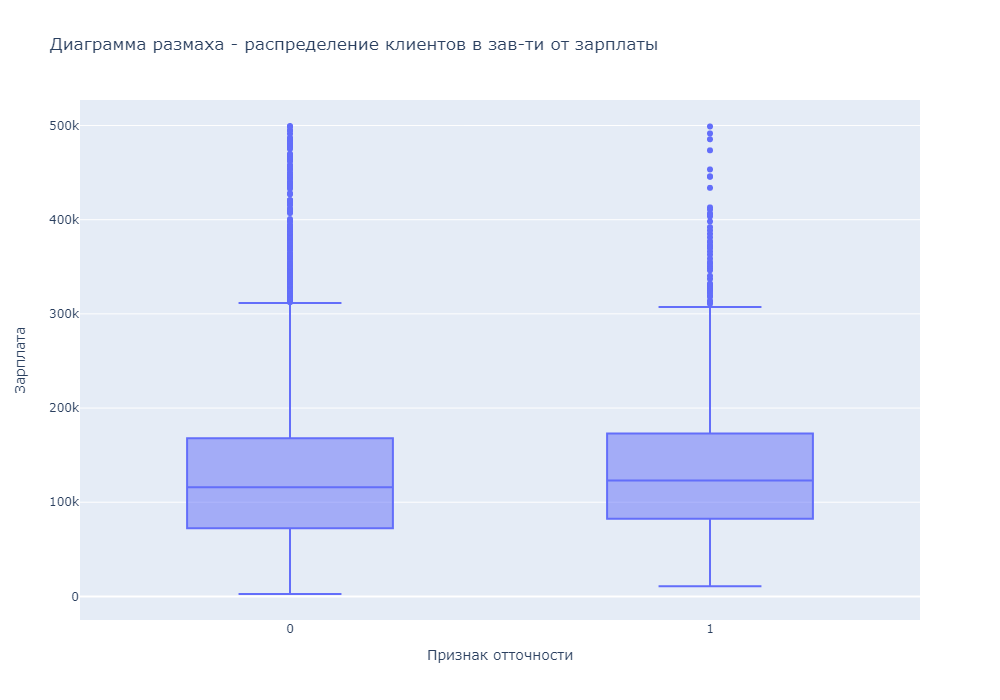

In [33]:
df_to_salary = df.query('est_salary <=500000')


fig = px.histogram(df_to_salary, x='est_salary', color="churn", histnorm='probability', 
                   barmode ='overlay',width=1000,height =800,
                   labels={
                 'est_salary': 'Зарплата'
             },
                  title="Гистограмма распределения клиентов в зав-ти от зарплаты в разрезе отток/не отток")
fig.update_layout(yaxis_title="%") 
fig.show()

fig = px.box(df_to_salary, x='churn', y='est_salary',width=1000,height =700,
                 labels={
                 'est_salary': 'Зарплата'
             },
             title = "Диаграмма размаха - распределение клиентов в зав-ти от зарплаты")
fig.update_layout(xaxis_title="Признак отточности") 

fig.show()

Медианная ЗП отточных/нет клиентов выше у отточных ~ *123 K*. Основыне интервалы, где отток выше:
* 75 - 90 К,
* 100 - 135 К,
* 145- 165 К, 
* 170 - 180 К, 
* 185 - 190 К, 
* 190 - 215 К. 
Позднее оценим общую корреляцию данного признака. 

**В.** *Перейдем к оценке корреляции.*

In [34]:
# корреляцуию будем оценивать при помощи библиотеки phik
cols_to_keep = ['score', 'city', 'gender','age', 'equity', 'balance',
                'products', 'credit_card', 'last_activity', 'est_salary','churn']

interval_cols = ['score', 'age', 'balance', 'est_salary']

df_to_correlation = df[cols_to_keep]

In [35]:
phik_overview = df_to_correlation.phik_matrix(interval_cols=interval_cols)
phik_overview.round(2)

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
score,1.00,0.09,0.07,0.04,0.53,0.17,0.31,0.21,0.05,0.40,0.23
city,0.09,1.00,0.01,0.09,0.06,0.04,0.22,0.07,0.03,0.17,0.02
gender,0.07,0.01,1.00,0.29,0.06,0.05,0.12,0.20,0.01,0.14,0.22
age,0.04,0.09,0.29,1.00,0.05,0.03,0.13,0.16,0.09,0.36,0.18
equity,0.53,0.06,0.06,0.05,1.00,0.00,0.44,0.22,0.05,0.29,0.35
balance,0.17,0.04,0.05,0.03,0.00,1.00,0.00,0.00,0.00,0.37,0.02
products,0.31,0.22,0.12,0.13,0.44,0.00,1.00,0.46,0.19,0.16,0.44
credit_card,0.21,0.07,0.20,0.16,0.22,0.00,0.46,1.00,0.05,0.04,0.20
last_activity,0.05,0.03,0.01,0.09,0.05,0.00,0.19,0.05,1.00,0.05,0.26
est_salary,0.40,0.17,0.14,0.36,0.29,0.37,0.16,0.04,0.05,1.00,0.05


C:\Users\Natalya\AppData\Local\Temp\ipykernel_7644\2148959659.py:8: UserWarning:

The figure layout has changed to tight



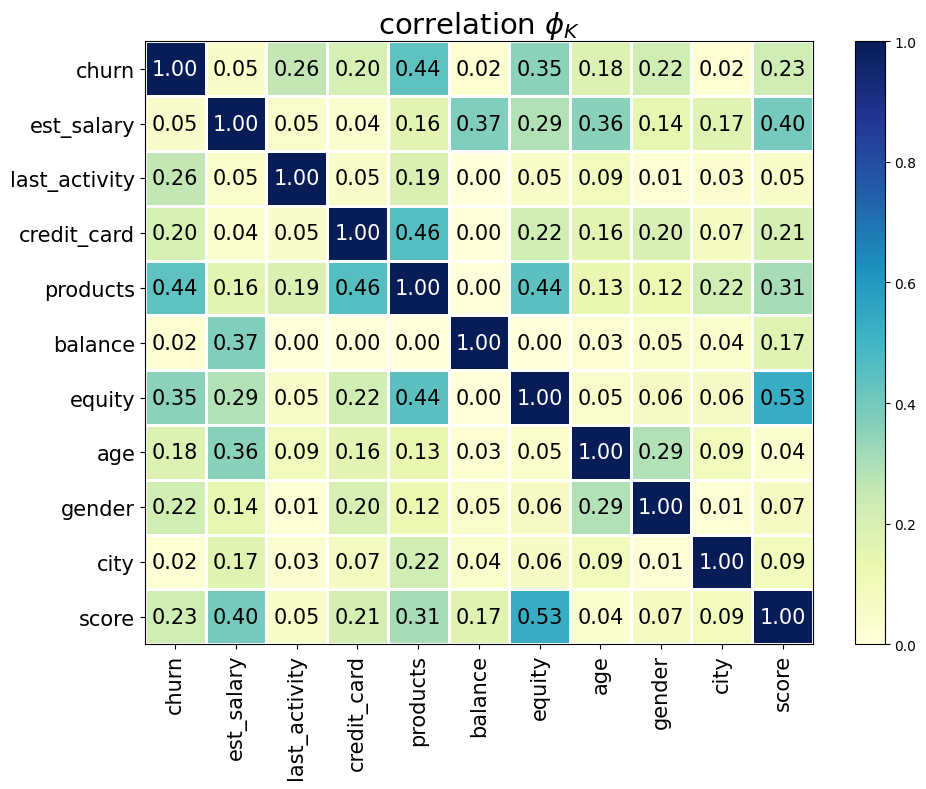

In [36]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map = 'YlGnBu', 
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

C:\Users\Natalya\AppData\Local\Temp\ipykernel_7644\1361305389.py:9: UserWarning:

The figure layout has changed to tight



,churn,Оценка по шк.Чеддока
score,0.228179,слабая
city,0.016811,слабая
gender,0.218799,слабая
age,0.183306,слабая
equity,0.352726,умеренная
balance,0.024701,слабая
products,0.441363,умеренная
credit_card,0.202997,слабая
last_activity,0.261174,слабая
est_salary,0.047635,слабая


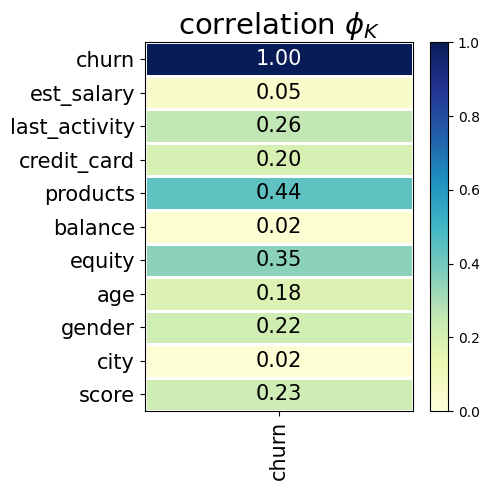

In [37]:
phik_overview_churn = phik_overview[['churn']]
plot_correlation_matrix(phik_overview_churn.values, 
                        x_labels=phik_overview_churn.columns, 
                        y_labels=phik_overview_churn.index, 
                        vmin=0, vmax=1, color_map = 'YlGnBu', 
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1.5, 
                        figsize=(5, 5))
plt.tight_layout()

def calc_for_Chaddock(value):
    
    if value < 0.3:
        return 'слабая'
    elif 0.3 <= value < 0.5:
         return 'умеренная'
    elif 0.5 <= value < 0.7:    
        return 'заметная'
    elif 0.7 <= value < 0.9: 
        return 'высокая'
    else:
        return 'сильная'


phik_overview_churn['Оценка по шк.Чеддока'] = phik_overview_churn['churn'].apply(calc_for_Chaddock)
display(phik_overview_churn)


При оценке корреляции видим, в том числе, и ранее отмеченные закономерности( далее признаки в порядке убывания корреляции):

* products - кол-во продуктов,
* equity - баллы владения недвижимостью,
* last_activiry - активность,
* score - кредитный рейтинг. 

Согласно шкале Чеддока лишь 2 признака имеют умеренную корреляцию - products и equity, у остальных связь слабая. 

**Г.** *Портрет клиента.*

Посмотрим более прицельно на ряд признаков, учтем их особенности(выберем более корретную меру центральной тенденции), учтем и категориальные признаки.

In [38]:
churn_to_source = df.query('balance <=20000000').groupby('churn')\
    .agg({ 'est_salary' : 'mean', 'age' : 'mean',
           'score' : 'mean', 'balance' : 'mean',
           'products': 'median', 'equity': 'median',
           'gender' : pd.Series.mode, 'city': pd.Series.mode,
           'credit_card' : pd.Series.mode, 'last_activity': pd.Series.mode
          }).round(2).T
churn_to_source = churn_to_source.rename(columns={0: "Не отток", 1: "Отток"})

def calc_diff_1(row):
    if row.name in ['est_salary', 'age', 'score', 'balance', 'products', 'equity']:
        return ((row['Не отток'] - row['Отток'])/ row['Не отток']) * 100
    else:
        return '-'

churn_to_source['Относительная разница,%'] = churn_to_source.apply(calc_diff_1, axis=1)
display(churn_to_source)


churn,Не отток,Отток,"Относительная разница,%"
est_salary,117313.91,146629.62,-24.989117
age,43.38,41.4,4.564315
score,837.58,863.45,-3.08866
balance,694103.51,1087730.46,-56.710122
products,2.0,2.0,0.0
equity,3.0,4.0,-33.333333
gender,Ж,М,-
city,Ярославль,Ярославль,-
credit_card,1,1,-
last_activity,0,1,-


Портрет отточного клиента:
    
* активный клиент; мужчина, средний возраст 41 - 42 года,
* средняя зарплата ~ 147.000,
* средний кредитный рейтинг 863.45,
* средний баланс ~ 1 087 730.46
* в среднем 2 продукта в пользовании, 
* в среднем 4 балла по оценке объектов недвижимости в пользовании,
* в обоих случаях мода по городу Ярославль, но стоит помнить, что это и "источник" наибольшего числа клиентов.
* в обоих случаях мода по к.карте говорит в пользу наличия, но стоит помнить, что таких клиентов 70 % от общего числа, а при прицельной оценке % оттока среди не имеющих к.карту выше.

**Шаг 3. Итоги:**

1) Общее: 

* макс возраст клиента банка 86 лет
* оценка объектов нед-ти/кол во их в собественности варьируется от 0 до 9
* макс кол-во продуктов в пользовании - 5
* 68 % клиентов пользуются кредитной картой
* неактивные клиенты ~ 50 %
* общий % оттока ~ 18 %


2) По категориальным признакам: 

* Соотношение женщины/мужчины среди клиентов банка практически **1:1** *(4995 / 5005).* Однако, отточных среди мужчин больше,чем среди женщин. *М* - **23,64 %**( выше общебанковского оттока), *Ж* - **12,75 %.**


* Самый низкий % оттока в Рыбинске. Практически одинаковый в Ярославле и Ростове ( 18.97% и 18.77%) и на уровне общебанковского. 


* По кол-ву баллов собственности мы видим прогрессирующее увеличение % отточных клиентов с увеличением балла. Макс % оттока - 53.85 %. Отметим, что 25 % от всех клиентов имеют балл 0.


* По кол-ву продуктов, также, видим прогрессирующее увеличение % отточных клиентов с увеличением кол-ва продуктов. Макс % оттока - 63.29 %(4 продукта). Отметим, что 50 % от всех клиентов пользуются 2-мя продуктами. 


* ~ 70 %(6804) клиентов банка имеют кредитную карту, при этом % отточных среди них ниже среднебанковского - 14.74 %. А вот среди не имеющих кредитную карту - 25.56%


* Соотношение активные/неактивные среди клиентов банка близко к 1:1 (4765 / 5235). Однако, отточных больше среди активных - 24.41 %( выше общебанковского оттока).


3) По числовым признакам: 


* Медианный возраст отточных/нет клиентов практически аналогичен (39/40). В интервале 25 - 35 лет и 50 - 60 лет отток преобладает.


* Медианный кредитный рейтинг отточных/нет клиентов выше у отточных - 866. В интервалах 820 - 829, 835 - 909, 920 - 934 отток преобладает.


* Медианный баланс отточных/нет клиентов выше у отточных ~ 780 K. Начиная с 750 К отток начинает стабильно преобладать.


* Медианная ЗП отточных/нет клиентов выше у отточных ~ 123 K. Основыне интервалы, где отток выше:

- 75 - 90 К,
- 100 - 135 К,
- 145- 165 К,
- 170 - 180 К,
- 185 - 190 К,
- 190 - 215 К. 


4) При оценке корреляции - признаки в порядке ее убывания:

* products - кол-во продуктов,
* equity - баллы владения недвижимостью,
* last_activiry - активность,
* score - кредитный рейтинг,
* gender - пол.


5) Портрет отточного клиента:

* активный клиент; мужчина, средний возраст 41 - 42 года,
* средняя зарплата ~ 147.000,
* средний кредитный рейтинг 863.45,
* средний баланс ~ 1 087 730.46
* в среднем 2 продукта в пользовании, 
* в среднем 4 балла по оценке объектов недвижимости в пользовании,
* в обоих случаях мода по городу Ярославль, но стоит помнить, что это и "источник" наибольшего числа клиентов.
* в обоих случаях мода по к.карте говорит в пользу наличия, но стоит помнить, что таких клиентов 70 % от общего числа, а при прицельной оценке, % оттока среди не имеющих к.карту выше. 

###### Шаг 4. Формулировка и проверка статистических гипотез.

**Гипотеза № 1**

**Н0 (нулевая гипотеза)** - средние заработные платы отточных и не отточных клиентов равны.

**Н1 (альтернативная гипотеза)** - средние заработные платы отточных и не отточных клиентов равны.

Предварительно оценим распределение. 

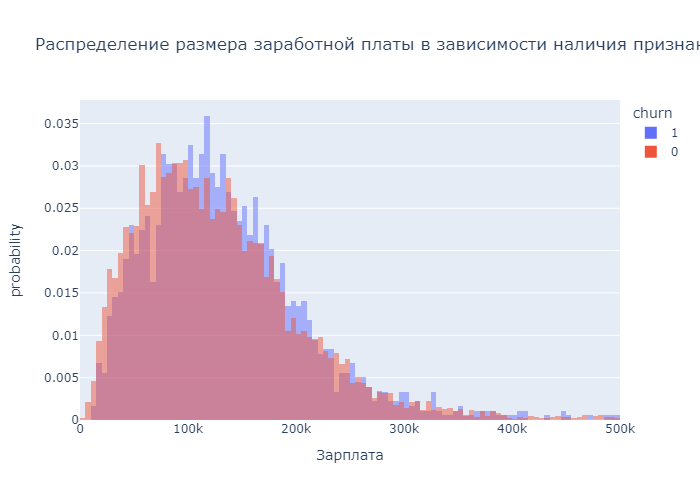

In [39]:
fig = px.histogram(df_to_salary, x='est_salary', color="churn", histnorm='probability', barmode ='overlay',
                       labels={
                     'est_salary': 'Зарплата'
                 },
                      title='Распределение размера заработной платы в зависимости наличия признака отточности')
fig.show()

У нас более 5000 наблюдений, в связи с чем использование тестов на "нормальность" распределения не обосновано.

Согласно гистограмме, распределение близко к нормальному, со смещением. 

Помним, что, ЦПТ  позволяет утверждать, что всегда, когда случайная величина образуется в результате сложения большого числа независимых случайных величин, дисперсии которых малы по сравнению с дисперсией суммы, закон распределения этой случайной величины оказывается практически нормальным законом. А поскольку случайные величины всегда порождаются бесконечным количеством причин и чаще всего ни одна из них не имеет дисперсии, сравнимой с дисперсией самой случайной величины, то большинство встречающихся в практике случайных величин подчинено нормальному закону распределения.

А значит, в данной ситуации можем считать допустимым использование t-тест Стьюдента
Дополнительно добавим параметр - *equal_var=False*

In [40]:
alpha = .05   # критический уровень статистической значимости    
results = st.ttest_ind(df[df['churn'] == 1]['est_salary'], 
                             df[df['churn'] == 0]['est_salary'],equal_var=False)

print('p-значение: ', results.pvalue)    # тест двухсторонний

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.8887054822123845
Не получилось отвергнуть нулевую гипотезу


**Гипотеза № 2**

**Н0 (нулевая гипотеза)** - средние кредитные рейтинги(score) у отточных и не отточных клиентов равны.

**Н1 (альтернативная гипотеза)** - средние кредитные рейтинги(score) у отточных и не отточных клиентов отличаются.

Предварительно оценим распределение.

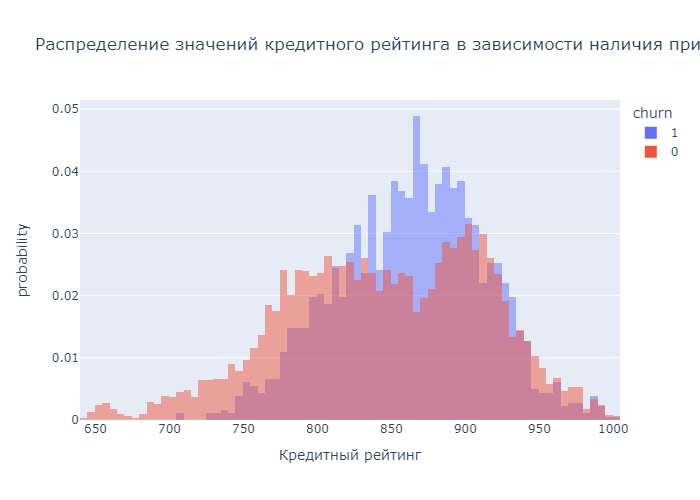

In [41]:
fig = px.histogram(df, x='score', color="churn", histnorm='probability', barmode ='overlay',
                       labels={
                     'score': 'Кредитный рейтинг'
                 },
                      title='Распределение значений кредитного рейтинга в зависимости наличия признака отточности')
fig.show()

In [42]:
alpha = .05   # критический уровень статистической значимости   

results = st.ttest_ind(df[df['churn'] == 0]['score'], 
                             df[df['churn'] == 1]['score'],
                             equal_var=False)

print('p-значение: ', results.pvalue)    # тест двухсторонний

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.2043086927657869e-37
Отвергаем нулевую гипотезу


**Шаг 4. Итоги:**

* Гипотеза № 1 - *средние заработные платы отточных и не отточных клиентов равны* - не получилось отвергнуть нулевую гипотезу.

* Гипотеза № 2 - средние кредитные рейтинги(score) у отточных и не отточных клиентов равны - отвергаем нулевую гипотезу в пользу альтернативной - *средние кредитные рейтинги(score) у отточных и не отточных клиентов отличаются.*

##### Шаг 5. Сегментация.

Для выделения сегментов, возьмем попарно/более несколько признаков, имеющих корреляцию с оттоком. 

In [43]:
# первая пара - products и credit_card
# предполагаем,что в такой сегмент попадут давние "друзья" банка, вероятно, имеющие в продуктах и кредиты + кр.карты

first_segment = df.query('products >=3 and credit_card ==1')
display(first_segment.describe())
churn_first_segment = first_segment.groupby('churn')\
    .agg({ 'user_id': 'count',
           'gender' : pd.Series.mode
          }).round(2).T
churn_first_segment = churn_first_segment.rename(columns={0: "Не отток", 1: "Отток"})
churn_first_segment

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_Nan
count,712.000000,712.000000,712.000000,712.000000,6.960000e+02,712.000000,712.0,712.000000,7.120000e+02,712.000000,712.000000
mean,173485.456461,844.820225,42.054402,3.705056,1.050079e+06,3.507022,1.0,0.540730,1.327635e+05,0.477528,0.022472
std,33711.787463,58.244055,12.182995,1.601714,1.469646e+06,0.551133,0.0,0.498689,1.275178e+05,0.499846,0.148317
min,95384.000000,689.000000,19.000000,0.000000,2.390000e+02,3.000000,1.0,0.000000,5.043140e+03,0.000000,0.000000
25%,146549.500000,798.750000,33.000000,3.000000,3.505541e+05,3.000000,1.0,0.000000,6.150072e+04,0.000000,0.000000
50%,174544.500000,839.500000,39.000000,4.000000,6.996734e+05,3.000000,1.0,1.000000,1.073652e+05,0.000000,0.000000
75%,201442.750000,888.000000,50.000000,5.000000,1.293716e+06,4.000000,1.0,1.000000,1.610091e+05,1.000000,0.000000
max,229009.000000,1000.000000,82.000000,9.000000,2.572776e+07,5.000000,1.0,1.000000,1.064019e+06,1.000000,1.000000


churn,Не отток,Отток
user_id,372,340
gender,М,М


**Первый сегмент:**

- 712 клиентов, отточных 340;
- общий отток 47,75 %;
- в общем больше мужчин,чем женщин;
- пользователи 3х и более продуктов;
- клиенты, имеющие кредитную карту.

In [44]:
# первая пара - equity и balance
# предполагаем,что в такой сегмент войдут клиенты с достатком выше среднего, на основании чего будет опр-на тактика работы

second_segment = df.query('equity >=4 and balance >850000 and credit_card==0')
display(second_segment.describe())
churn_second_segment = second_segment.groupby('churn')\
    .agg({ 'user_id': 'count',
           'gender' : pd.Series.mode
          }).round(2).T
churn_second_segment = churn_second_segment.rename(columns={0: "Не отток", 1: "Отток"})
churn_second_segment

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_Nan
count,803.000000,803.000000,803.000000,803.000000,8.030000e+02,803.000000,803.0,803.000000,8.030000e+02,803.000000,803.0
mean,174266.053549,884.003736,45.948941,4.689913,1.962418e+06,2.403487,0.0,0.565380,1.804294e+05,0.466999,0.0
std,36123.083614,49.524711,11.871029,0.669786,2.424509e+06,0.636847,0.0,0.496016,1.560197e+05,0.499221,0.0
min,96404.000000,739.000000,23.000000,4.000000,8.518967e+05,1.000000,0.0,0.000000,7.571800e+03,0.000000,0.0
25%,144380.000000,855.000000,36.000000,4.000000,1.127029e+06,2.000000,0.0,0.000000,9.902070e+04,0.000000,0.0
50%,176110.000000,893.000000,44.000000,5.000000,1.366389e+06,2.000000,0.0,1.000000,1.469866e+05,0.000000,0.0
75%,206307.000000,919.000000,56.000000,5.000000,1.986285e+06,3.000000,0.0,1.000000,2.053217e+05,1.000000,0.0
max,229058.000000,1000.000000,78.000000,9.000000,4.327710e+07,4.000000,0.0,1.000000,1.395064e+06,1.000000,0.0


churn,Не отток,Отток
user_id,428,375
gender,Ж,М


**Второй сегмент:**

- 803 клиента, отточных 375;
- общий отток 46,7 %;
- в оттоке преобладают мужчины;
- клиенты, имеющие от 4х и более баллов оценки недвижимости;
- клиенты, имеющие на балансе более 850.000;
- клиенты, не имеющие кредитной карты.

In [45]:
# для третьего сегмента возьмем клиентов активных, с хорошим кр.рейтингом, не имеющих кр.карты
# и балансом равным или менее 850000

third_segment = df.query('last_activity==1 and 835<= score <=930 and credit_card==0 and balance <= 850000')
display(third_segment.describe())
churn_third_segment = third_segment.groupby('churn')\
    .agg({ 'user_id': 'count',
           'gender' : pd.Series.mode
          }).round(2).T
churn_third_segment = churn_third_segment.rename(columns={0: "Не отток", 1: "Отток"})
churn_third_segment


,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_Nan
count,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.0,422.0,422.000000,422.000000,422.0
mean,165242.246445,867.774882,43.281361,3.834123,500763.247275,2.386256,0.0,1.0,104769.582275,0.502370,0.0
std,33405.830419,22.767941,14.795652,1.464049,199490.686211,0.745597,0.0,0.0,65762.107804,0.500588,0.0
min,94561.000000,835.000000,20.000000,0.000000,15017.210000,1.000000,0.0,1.0,9530.000000,0.000000,0.0
25%,138214.000000,849.000000,31.000000,3.000000,361174.867500,2.000000,0.0,1.0,57763.595000,0.000000,0.0
50%,165717.000000,863.000000,38.000000,4.000000,507724.400000,2.000000,0.0,1.0,93422.290000,1.000000,0.0
75%,190134.500000,884.000000,57.000000,5.000000,653756.617500,3.000000,0.0,1.0,134238.215000,1.000000,0.0
max,228075.000000,929.000000,81.000000,8.000000,848630.850000,4.000000,0.0,1.0,647475.080000,1.000000,0.0


churn,Не отток,Отток
user_id,210,212
gender,Ж,Ж


**Третий сегмент:**

* 422 клиента, отточных - 212;
* уровень оттока ~ 50,2 %;
* женщины преобладают как в оттоке, так и не в оттоке;
* активные клиенты;
* клиенты, имеющие кр.рейтинг от 835 до 930;
* клиенты, не имеющие кр.карты;
* клиенты, имеющие на балансе 850.000 или менее.

##### Шаг 6. Приоритизация сегментов.

В предыдущем шаге выделены 3 непересекающихся сегмента. Отток от 46,7 % до 50,2 %. Так как значения близкие в приоритизации учтем кол-во клиентов в сегменте. Следовательно, будет предложено обрабатывать в следующем порядке:

А)
- 803 клиента, отточных 375;
- общий отток 46,7 %;
- в оттоке преобладают мужчины;
- клиенты, имеющие от 4х и более баллов оценки недвижимости;
- клиенты, имеющие на балансе более 850.000;
- клиенты, не имеющие кредитной карты.

Б) 
- 712 клиентов, отточных 340;
- общий отток 47,75 %;
- в общем больше мужчин,чем женщин;
- пользователи 3х и более продуктов;
- клиенты, имеющие кредитную карту.

В)
* 422 клиента, отточных - 212;
* уровень оттока ~ 50,2 %;
* женщины преобладают как в оттоке, так и не в оттоке;
* активные клиенты;
* клиенты, имеющие кр.рейтинг от 835 до 930;
* клиенты, не имеющие кр.карты;
* клиенты, имеющие на балансе 850.000 или менее.

##### Шаг 7. Общие выводы, формирование рекомендаций.

**Итоговый вывод:**

В ходе исследования были проанализированы “особенности” **10.000** клиентов банка. 

*Было отмечено:*

* макс возраст клиента банка 86 лет
* оценка объектов нед-ти/кол во их в собественности варьируется от 0 до 9
* макс кол-во продуктов в пользовании - 5
* 68 % клиентов пользуются кредитной картой
* неактивные клиенты ~ 50 %
* общий % оттока ~ 18 %

*По категориальным признакам:*

* Соотношение женщины/мужчины среди клиентов банка практически 1:1 (4995 / 5005). Однако, отточных среди мужчин больше,чем среди женщин. М - 23,64 %( выше общебанковского оттока), Ж - 12,75 %.


* Самый низкий % оттока в Рыбинске. Практически одинаковый в Ярославле и Ростове ( 18.97% и 18.77%) и на уровне общебанковского. 


* По кол-ву баллов собственности мы видим прогрессирующее увеличение % отточных клиентов с увеличением балла. Макс % оттока - 53.85 %. Отметим, что 25 % от всех клиентов имеют балл 0.


* По кол-ву продуктов, также, видим прогрессирующее увеличение % отточных клиентов с увеличением кол-ва продуктов. Макс % оттока - 63.29 %(4 продукта). Отметим, что 50 % от всех клиентов пользуются 2-мя продуктами.


* ~ 70 %(6804) клиентов банка имеют кредитную карту, при этом % отточных среди них ниже среднебанковского - 14.74 %. А вот среди не имеющих кредитную карту - 25.56%


* Соотношение активные/неактивные среди клиентов банка близко к 1:1 (4765 / 5235). Однако, отточных больше среди активных - 24.41 %( выше общебанковского оттока).

*По числовым признакам:*

* Медианный возраст отточных/нет клиентов практически аналогичен (39/40). В интервале 25 - 35 лет и 50 - 60 лет отток преобладает.


* Медианный кредитный рейтинг отточных/нет клиентов выше у отточных - 866. В интервалах 820 - 829, 835 - 909, 920 - 934 отток преобладает.


* Медианный баланс отточных/нет клиентов выше у отточных ~ 780 K. Начиная с 750 К отток начинает стабильно преобладать.


* Медианная ЗП отточных/нет клиентов выше у отточных ~ 123 K. Основыне интервалы, где отток выше:
- 75 - 90 К, 
- 100 - 135 К, 
- 145- 165 К, 
- 170 - 180 К, 
- 185 - 190 К, 
- 190 - 215 К. 


*При оценке корреляции - признаки в порядке ее убывания:*

* products - кол-во продуктов,
* equity - баллы владения недвижимостью,
* last_activiry - активность,
* score - кредитный рейтинг,
* gender - пол.


*Портрет отточного клиента:*

* активный клиент; мужчина, средний возраст 41 - 42 года,
* средняя зарплата ~ 147.000,
* средний кредитный рейтинг 863.45,
* средний баланс ~ 1 087 730.46
* в среднем 2 продукта в пользовании, 
* в среднем 4 балла по оценке объектов недвижимости в пользовании,
* в обоих случаях мода по городу Ярославль, но стоит помнить, что это и "источник" наибольшего числа клиентов.
* в обоих случаях мода по к.карте говорит в пользу наличия, но стоит помнить, что таких клиентов 70 % от общего числа, а при прицельной оценке, % оттока среди не имеющих к.карту выше.

*При оценке гипотез:*

* Гипотеза № 1 - средние заработные платы отточных и не отточных клиентов равны - не получилось отвергнуть нулевую гипотезу.


* Гипотеза № 2 - средние кредитные рейтинги(score) у отточных и не отточных клиентов равны - отвергаем нулевую гипотезу в пользу альтернативной - средние кредитные рейтинги(score) у отточных и не отточных клиентов отличаются.


*Выделенные сегменты, с учетом приоритизации:* 


Первый сегмент:
- 803 клиентов, отточных 375;
- общий отток 46,7 %;
- в оттоке преобладают мужчины;
- клиенты, имеющие от 4х и более баллов оценки недвижимости;
- клиенты, имеющие на балансе более 850.000;
- клиенты, не имеющие кредитной карты.

Второй сегмент:
- 712 клиентов, отточных 340;
- общий отток 47,75 %;
- в общем больше мужчин,чем женщин;
- пользователи 3х и более продуктов;
- клиенты, имеющие кредитную карту.

Третий сегмент:
- 422 клиента, отточных - 212;
- уровень оттока ~ 50,2 %;
- женщины преобладают как в оттоке, так и не в оттоке;
- активные клиенты;
- клиенты, имеющие кр.рейтинг от 835 до 930;
- клиенты, не имеющие кр.карты;
- клиенты, имеющие на балансе 850.000 или менее.

**Рекомендации в разрезе сегментов:**

1. **Первый:** 4 и более баллов оценки недвижимости + без кредитной карты + с балансом более 850 000

Вероятно, это клиенты выше среднего класса, хорошо обеспеченные. Для удержания их, и принадлежащих им капиталов может быть рассмотрено введение особой группы вкладов с плавающим % в зависимости от суммы. Если у банка есть инвестиционный сегмент, можно привлечь таких клиентов бонусами/кэшбеком при открытии инвестиционного счета/покупке определенных акций/облигаций.

2. **Второй:** 3 и более продуктов + наличие кредитной карты.

Вероятно, эти клиенты в банке уже не первый год. Возможно, имеют несколько кредитов/ипотеку. Соответственно, можно подумать о возможности спец. предложений/условий, рефинансирования, снижений % -ставки, консолидации (объединение кредитов в один). 

3. **Третий:** активные клиенты, с хорошим кр.рейтингом + без кредитной карты + баланс 850 000 и менее

Это "широкий" сегмент, у клиентов неплохая кредитная история - хороший кр.рейтинг, при этом нет кредитных карт, это клиенты с различным доходом. Единственный сегмент, где преобладают женщины. 

Для данной группы можно продумать рекламную стратегию в отношении открытия кредитной карты, например, предложить бесплатное обслуживание навсегда и/или более длительный льготный период. 
Оценить в данном сегменте наиболее характерные категории трат, допустим - продовольственные магазины/строительные; разработать программы кэшбека, акции. 
 